# This Notebook will be used to train and test a CNN-Model that will be built from scratch with the intention of not using pre-trained models
## Author: MrHaso 2022 

### Imports

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras.layers import MaxPooling2D, Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

### Create Train/Test sets

#### Create Array of Images

In [2]:
chords = ["No_Chord","Am","B","C","D","Em","F","G"]
X = []
for folder in chords:
    output_path = "Images/class_"+folder+"/"
    for path in os.listdir(output_path):
        if os.path.isfile(os.path.join(output_path, path)):
            im = cv2.imread(os.path.join(output_path, path))
            X.append(im)
X = np.array(X)
print(X[:1])

[[[[170 169 173]
   [171 170 174]
   [170 171 175]
   ...
   [184 181 190]
   [195 188 195]
   [190 183 190]]

  [[170 169 173]
   [171 170 174]
   [169 170 174]
   ...
   [188 185 194]
   [187 183 189]
   [191 187 193]]

  [[169 168 172]
   [170 169 173]
   [168 169 173]
   ...
   [184 186 194]
   [187 186 195]
   [189 186 195]]

  ...

  [[157 157 157]
   [159 159 159]
   [161 159 158]
   ...
   [183 178 175]
   [184 179 176]
   [185 180 177]]

  [[164 160 155]
   [161 157 152]
   [160 157 153]
   ...
   [183 178 175]
   [184 179 176]
   [185 180 177]]

  [[163 157 150]
   [164 158 151]
   [163 159 154]
   ...
   [183 178 175]
   [184 179 176]
   [184 179 176]]]]


#### Create Labels

In [3]:
chords = ["No_Chord","Am","B","C","D","Em","F","G"]
labels = []
for folder in chords:
    output_path = "Images/class_"+folder+"/"
    for path in os.listdir(output_path):
        if os.path.isfile(os.path.join(output_path, path)):
            labels.append(folder)

y = pd.DataFrame(labels)
y = pd.factorize(y[0])[0].astype(np.uint16)

#### Train / Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(1770, 1770, 443, 443)

In [5]:
X_train.shape, y_train.shape

((1770, 64, 64, 3), (1770,))

In [6]:
K = len(set(y_train))
print(f"We have {K} classes")

We have 8 classes


4


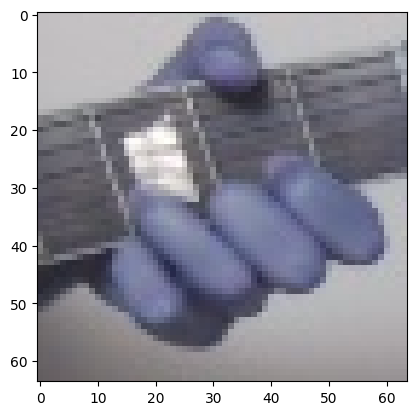

In [7]:
sample_im = 34
plt.imshow(X_test[sample_im]);
print(y_test[sample_im])

### Create CNN-Model

In [8]:
def build_simple_CNN():
    i = Input(shape=X_train[0].shape)
    x = Conv2D(64, (3,3), strides=2, activation="relu")(i)
    x = Conv2D(128, (3,3), strides=2, activation="relu")(x)
    x = Conv2D(256, (3,3), strides=2, activation="relu")(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(2048, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(K, activation="softmax")(x)

    model = Model(i,x)

    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [9]:
def build_complex_CNN():
    i = Input(shape=X_train[0].shape)
    x = Conv2D(64, (3,3), activation="relu", padding="same")(i)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(2048, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(K, activation="softmax")(x)

    model = Model(i,x)
    model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    
    batch_size= 32
    data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                                                                     height_shift_range=0.1,
                                                                     horizontal_flip=True)
    data_generator.fit(X_train)
    train_generator = data_generator.flow(X_train,y_train,batch_size)
    steps_per_epoch = X_train.shape[0] // batch_size
    
    return model, train_generator, steps_per_epoch
    

In [31]:

path_checkpoint = "training_1/cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)


In [11]:
simple_model = build_simple_CNN()
simple_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout (Dropout)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 2048)              256921

In [12]:
complex_model, train_generator, steps_per_epoch = build_complex_CNN()

complex_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0   

### Train and Test the Model

In [32]:
simple_r = simple_model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[save_model,early_stopping])

Epoch 1/50
55/56 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9898
Epoch 1: saving model to training_1\cp.ckpt
56/56 [==============================] - 4s 71ms/step - loss: 0.0329 - accuracy: 0.9898 - val_loss: 0.1524 - val_accuracy: 0.9661
Epoch 2/50
55/56 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9903
Epoch 2: saving model to training_1\cp.ckpt
56/56 [==============================] - 4s 65ms/step - loss: 0.0225 - accuracy: 0.9904 - val_loss: 0.0315 - val_accuracy: 0.9910
Epoch 3/50
55/56 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9778
Epoch 3: saving model to training_1\cp.ckpt
56/56 [==============================] - 4s 66ms/step - loss: 0.0821 - accuracy: 0.9780 - val_loss: 0.0611 - val_accuracy: 0.9842
Epoch 4/50
55/56 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9761
Epoch 4: saving model to training_1\cp.ckpt
56/56 [==============================] - 4s 65ms/step - lo

In [14]:
complex_r = complex_model.fit(train_generator,validation_data=(X_test,y_test),steps_per_epoch=steps_per_epoch,epochs=50,callbacks=[early_stopping])

Epoch 1/50
55/55 [==============================] - 12s 169ms/step - loss: 6.2667 - accuracy: 0.7491 - val_loss: 2458.3042 - val_accuracy: 0.3589
Epoch 2/50
55/55 [==============================] - 5s 88ms/step - loss: 0.7817 - accuracy: 0.9137 - val_loss: 731.8578 - val_accuracy: 0.3589
Epoch 3/50
55/55 [==============================] - 5s 88ms/step - loss: 0.4879 - accuracy: 0.9494 - val_loss: 41.0261 - val_accuracy: 0.4470
Epoch 4/50
55/55 [==============================] - 5s 88ms/step - loss: 0.2455 - accuracy: 0.9753 - val_loss: 35.3974 - val_accuracy: 0.5079
Epoch 5/50
55/55 [==============================] - 5s 89ms/step - loss: 0.5494 - accuracy: 0.9453 - val_loss: 24.5207 - val_accuracy: 0.6163
Epoch 6/50
55/55 [==============================] - 5s 88ms/step - loss: 0.3600 - accuracy: 0.9747 - val_loss: 13.8415 - val_accuracy: 0.6095
Epoch 7/50
55/55 [==============================] - 5s 89ms/step - loss: 0.3296 - accuracy: 0.9689 - val_loss: 4.1423 - val_accuracy: 0.8104
Ep

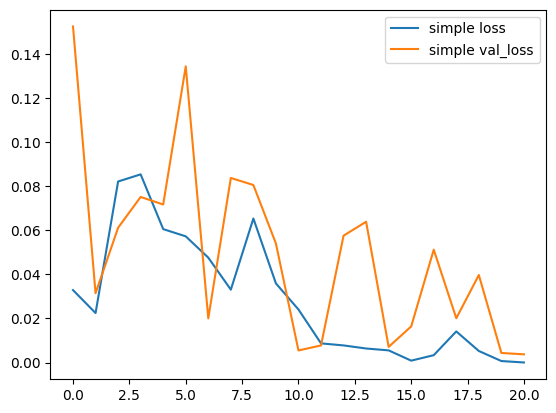

In [33]:
plt.plot(simple_r.history["loss"],label="simple loss")
plt.plot(simple_r.history["val_loss"],label="simple val_loss")
plt.legend();

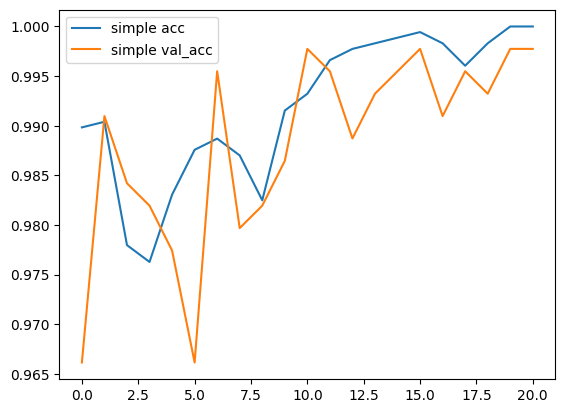

In [34]:
plt.plot(simple_r.history["accuracy"],label="simple acc")
plt.plot(simple_r.history["val_accuracy"],label="simple val_acc")
plt.legend();

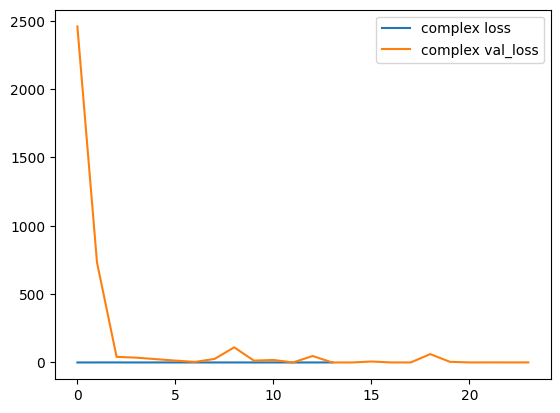

In [20]:
plt.plot(complex_r.history["loss"],label="complex loss")
plt.plot(complex_r.history["val_loss"],label="complex val_loss")

plt.legend();

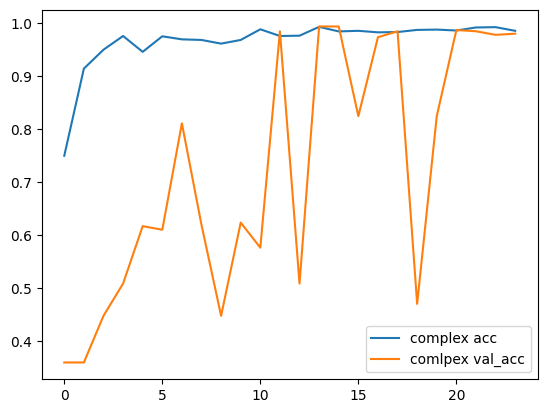

In [18]:
plt.plot(complex_r.history["accuracy"],label="complex acc")
plt.plot(complex_r.history["val_accuracy"],label="comlpex val_acc")
plt.legend();

### Live Detection

In [ ]:
loaded_model = build_CNN()

loss_, accuracy_ = loaded_model.evaluate(X_test, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * accuracy_))

In [ ]:
loaded_model.load_weights(path_checkpoint)

loss_, accuracy_ = loaded_model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * accuracy_))

In [ ]:
!mkdir -p saved_model
loaded_model.save('saved_model/loaded_model')

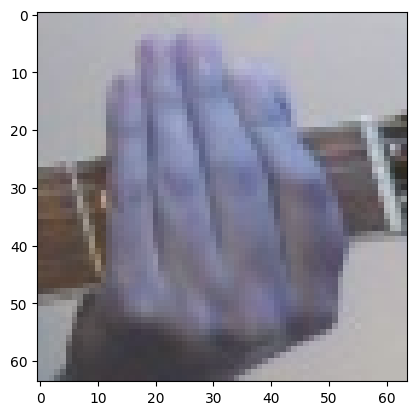

In [22]:
plt.imshow(X_test[24]);

In [26]:
x = X_test[24]
y = np.expand_dims(x, axis=0)
predictions = complex_model.predict(y)
print(predictions)

1/1 [==============================] - 1s 701ms/step
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 3.7917804e-31]]


In [27]:
unique_labels=[0,1,2,3,4,5,6,7,8]

In [28]:
index = 24
print(predictions)
print(f"Max value (probability of prediction): {np.max(predictions)}")
print(f"Sum: {np.sum(predictions)}")
print(f"Max index: {np.argmax(predictions)}")
print(f"Predicted label: {unique_labels[np.argmax(predictions)]}")
print(f"Correct label: {y_test[index]}")

[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 3.7917804e-31]]
Max value (probability of prediction): 1.0
Sum: 1.0
Max index: 0
Predicted label: 0
Correct label: 0


In [35]:
chords = ["No_Chord","Am","B","C","D","Em","F","G"]

# Setup camera attributes to take pictures with HD-USB Cam 
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cam.set(10,150)
cam.set(cv2.CAP_PROP_FPS, 30.0)
cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter.fourcc('m','j','p','g'))
cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter.fourcc('M','J','P','G'))
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

size=(64,64)

while True:

    ret, frame = cam.read()
    frame = frame[0:120,0:120]
    
    frame2 = cv2.resize(frame,size)
    frame = cv2.flip(frame,1)
    frame2 = np.expand_dims(frame2, axis=0)
    frame3 = cv2.resize(frame,(480,480))
    res = simple_model.predict(frame2)
    cv2.putText(frame3,chords[np.argmax(res)],(20,50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 8, cv2.LINE_AA)
    

    cv2.imshow("CAM",frame3)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    
cam.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step
